In [34]:
import pandas as pd
import numpy as np

import jax.numpy as jnp
import jax
from jax import config
config.update("jax_enable_x64", True)

import os, sys
sys.path.insert(0, "/home/storage/hans/jax_reco_new")

from lib.geo import closest_point_on_track, closest_distance_dom_track
from lib.simdata_i3 import I3SimHandler
from dom_track_eval import get_eval_network_doms_and_track_altrho as get_eval_network_doms_and_track
from lib.network import get_network_eval_v_fn
from lib.plotting import plot_event

In [62]:
# Get an IceCube event.
event_index = 0

bp = '/home/storage2/hans/i3files/21217'
sim_handler = I3SimHandler(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco/data/icecube/detector_geometry.csv')

meta, pulses = sim_handler.get_event_data(event_index)
print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)
fitting_data = event_data[['x', 'y', 'z', 'time', 'charge']].to_numpy()

# MC Truth:
track_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
track_time = meta['muon_time']
track_zenith = meta['muon_zenith']
track_azimuth = meta['muon_azimuth']
track_src = jnp.array([track_zenith, track_azimuth])

muon energy: 2.1 TeV


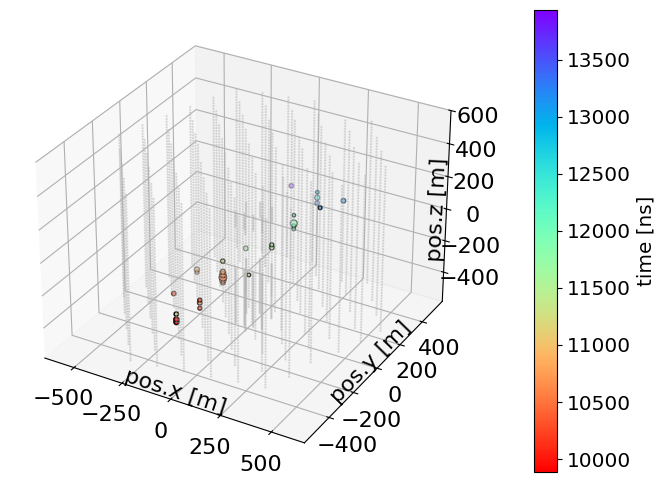

In [63]:
geo = pd.read_csv('/home/storage/hans/jax_reco/data/icecube/detector_geometry.csv')
plot_event(event_data, geo=geo)

In [64]:
dtype = jnp.float32
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco/data/network',
                                       dtype=dtype)
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v, dtype=dtype)

In [65]:
dom_pos = fitting_data[:, :3]
first_hit_times = fitting_data[:, 3]

logits, av, bv, geo_time = eval_network_doms_and_track(dom_pos, track_pos, track_src)
mix_probs = jax.nn.softmax(logits)
delay_time = first_hit_times - (geo_time + track_time)

In [66]:
np.min(delay_time)

Array(-0.58678536, dtype=float64)

In [98]:
from lib.geo import closest_distance_dom_track_v
from lib.geo import get_xyz_from_zenith_azimuth
from lib.geo import cherenkov_cylinder_coordinates_w_rho_v

track_dir_xyz = get_xyz_from_zenith_azimuth(track_src) 
_, closest_approach_dist, closest_approach_z, closest_approach_rho = \
    cherenkov_cylinder_coordinates_w_rho_v(dom_pos, track_pos, track_dir_xyz)

In [99]:
from lib.cgamma import c_multi_gamma_prob
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from lib.plotting import adjust_plot_1d

In [100]:
xvals = jnp.linspace(-10, 100, 1000)
xvals = xvals.reshape(1000, 1)
m = mix_probs[0]
a = av[0]
b = bv[0]
yvals = c_multi_gamma_prob(xvals, m, a, b, 3.0, 0.1)

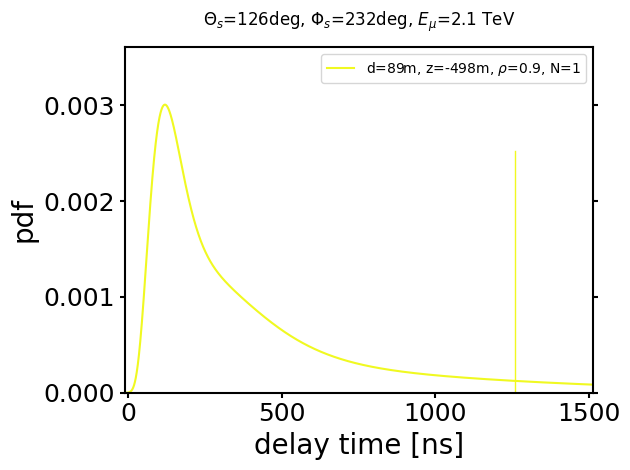

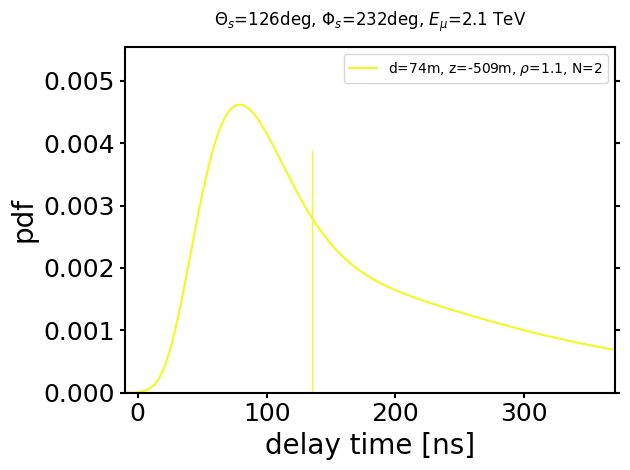

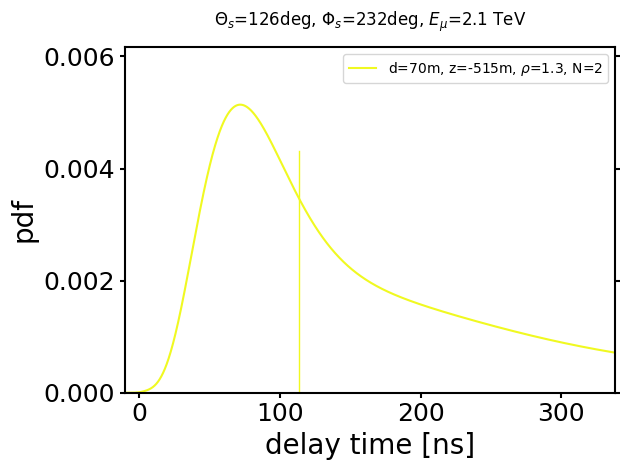

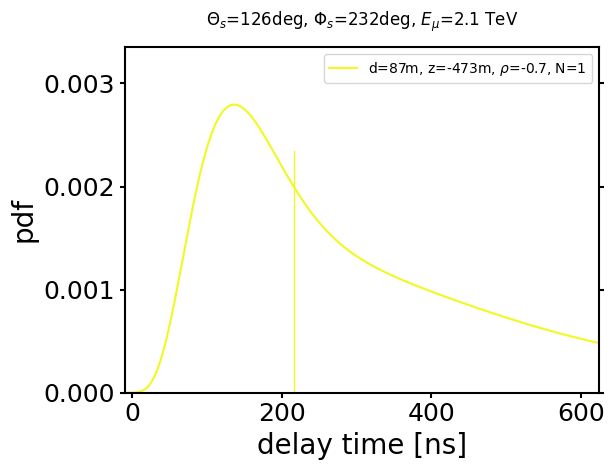

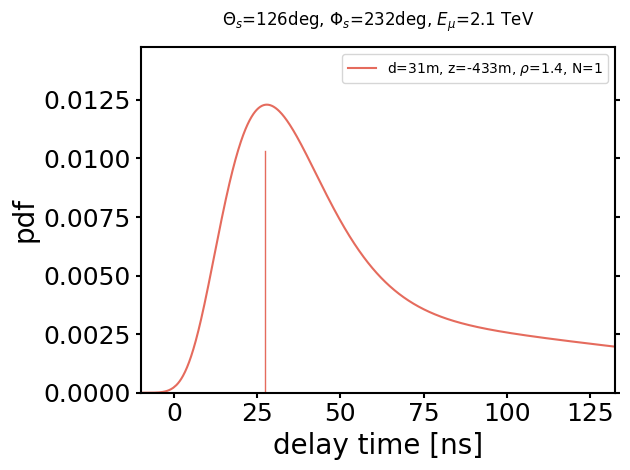

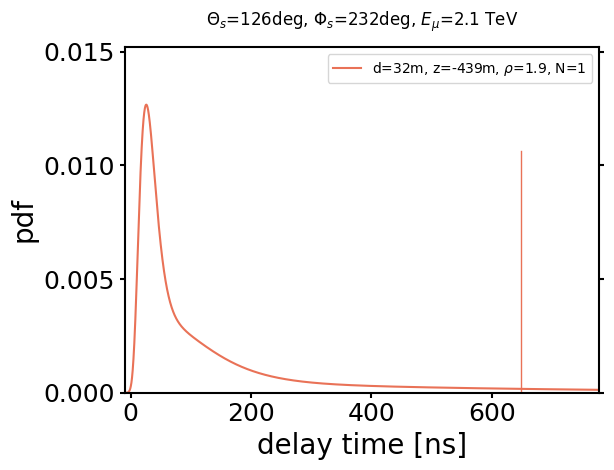

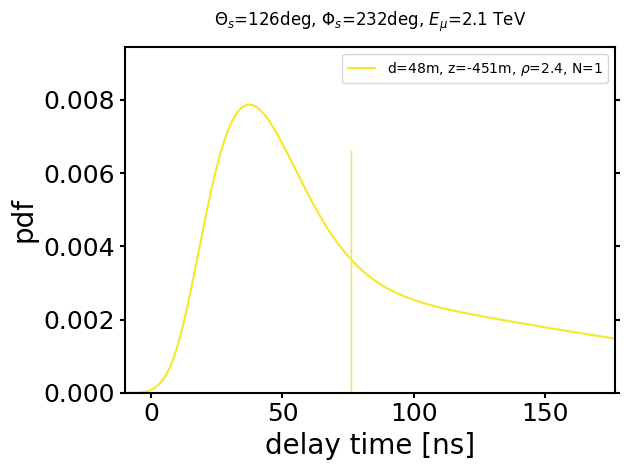

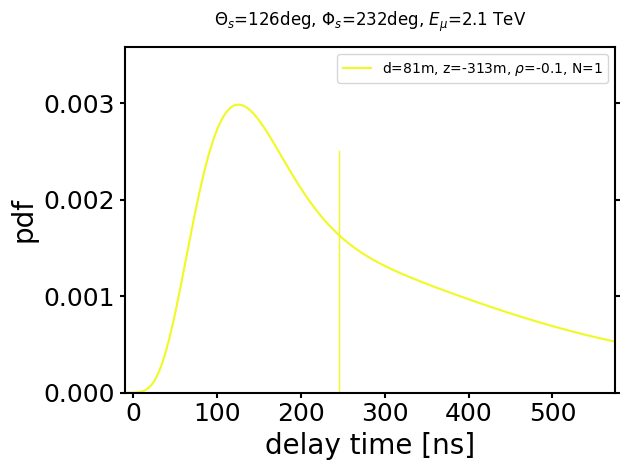

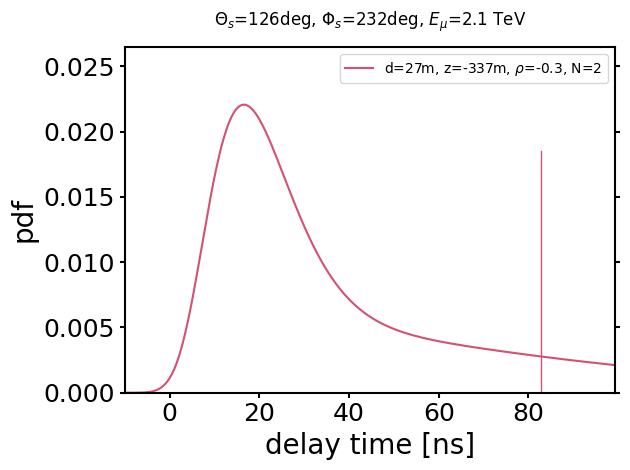

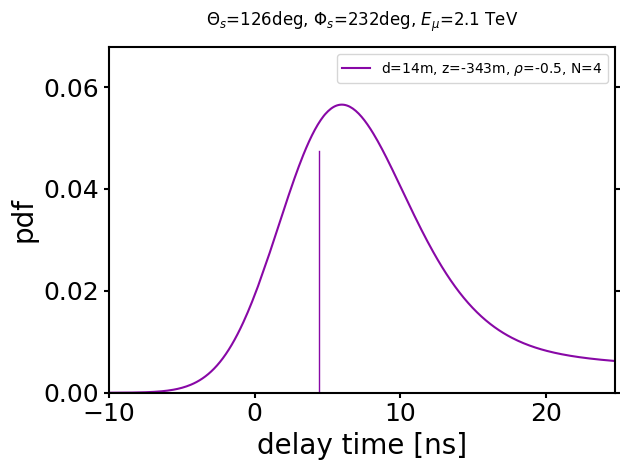

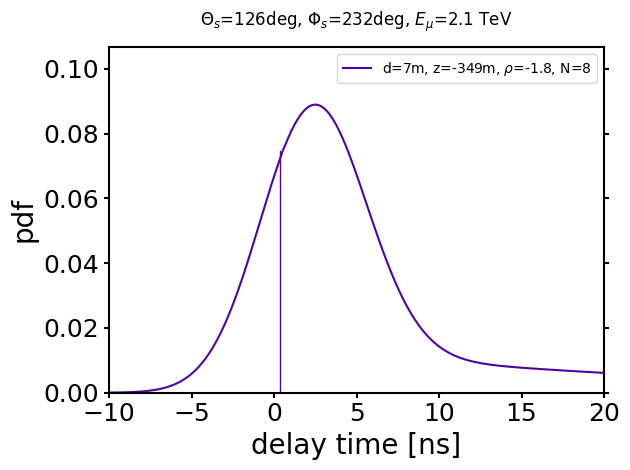

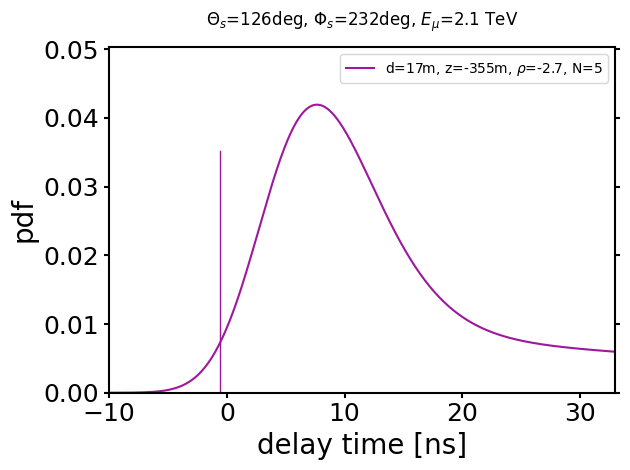

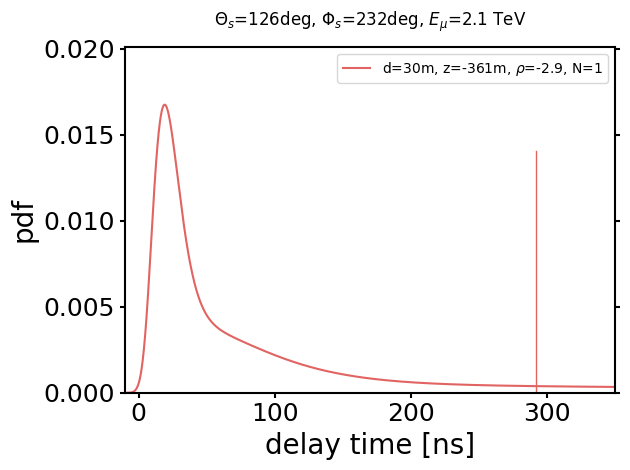

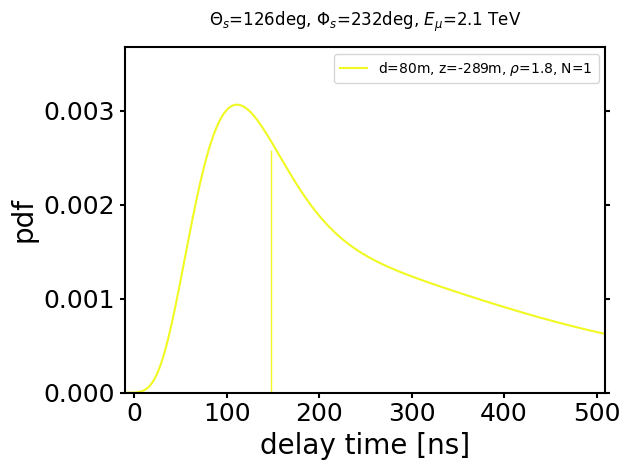

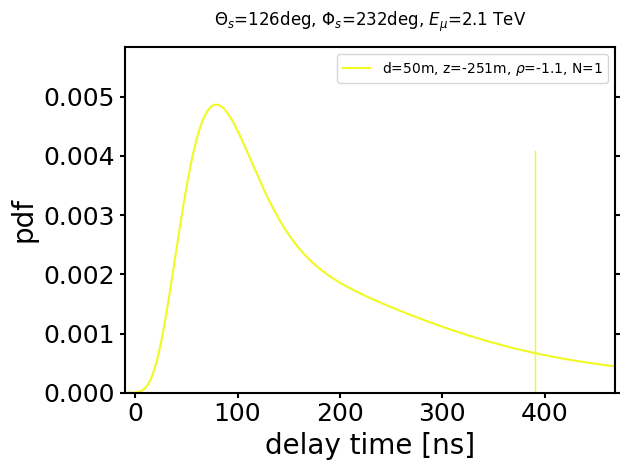

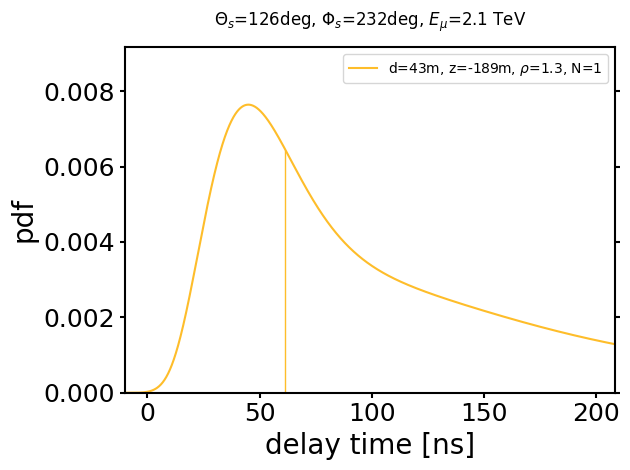

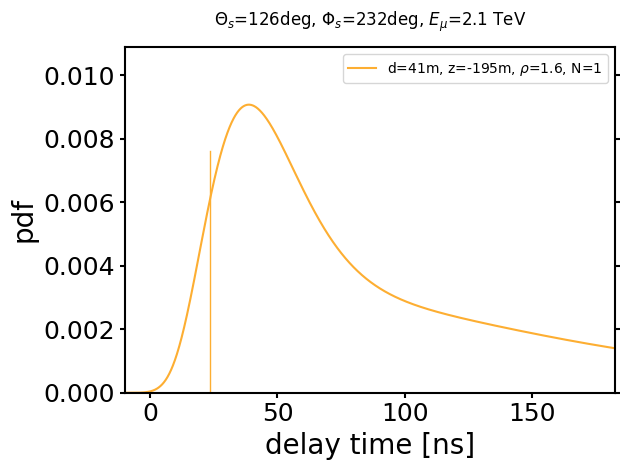

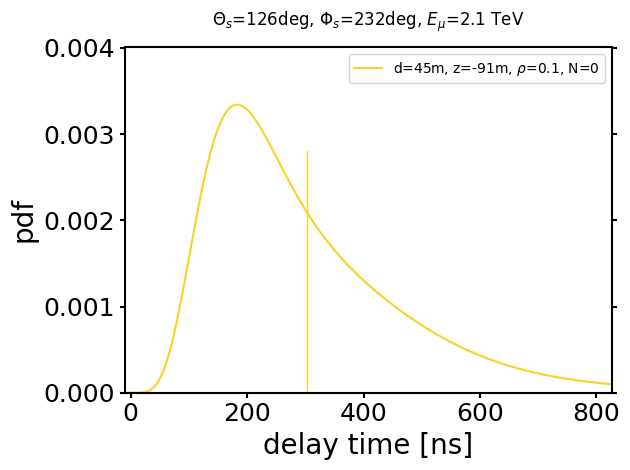

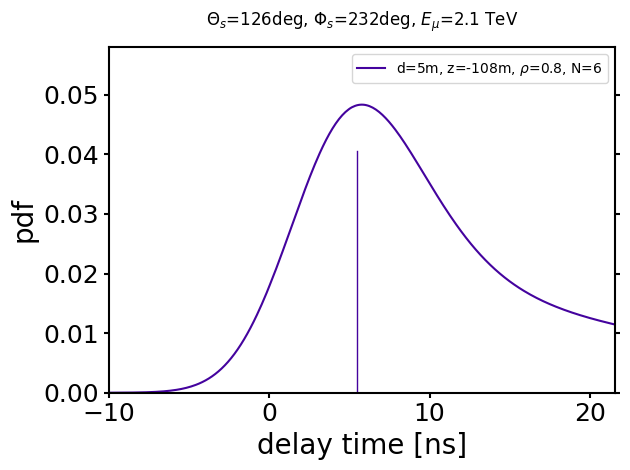

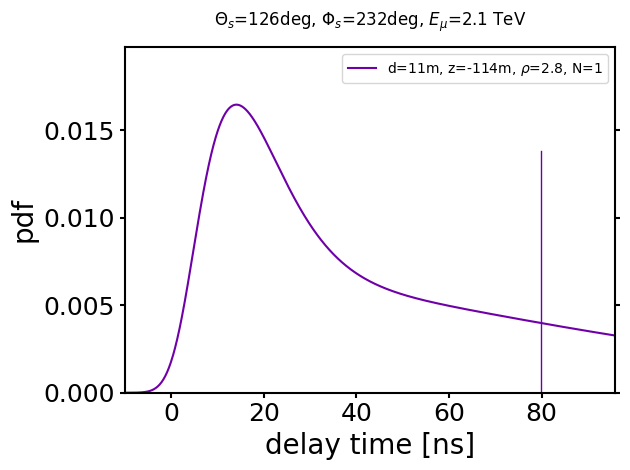

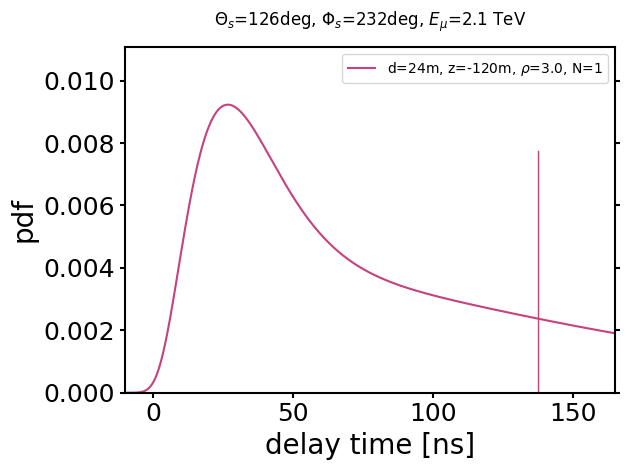

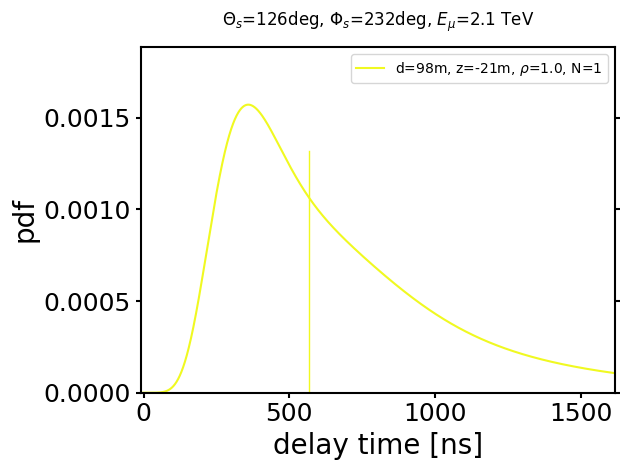

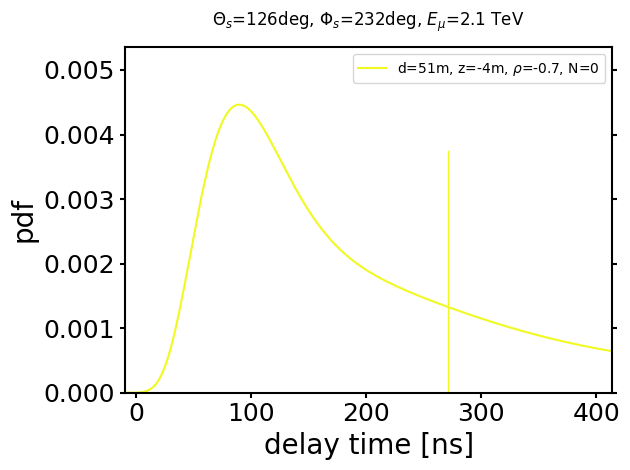

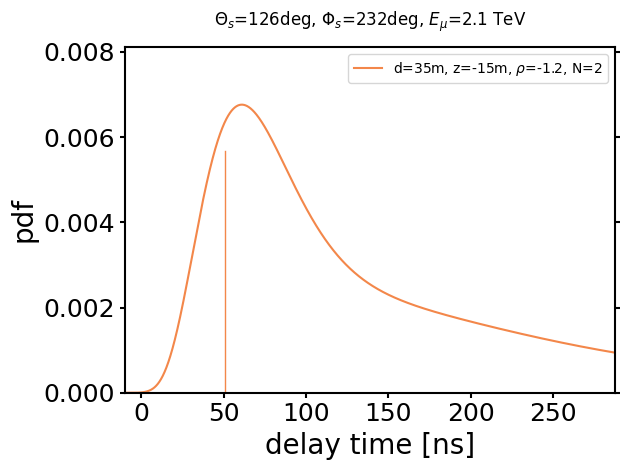

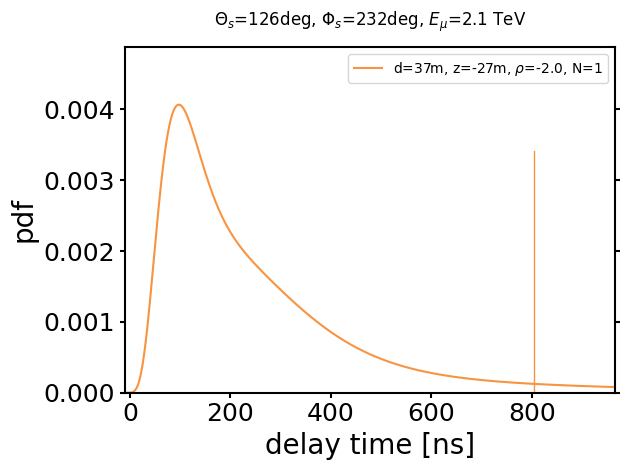

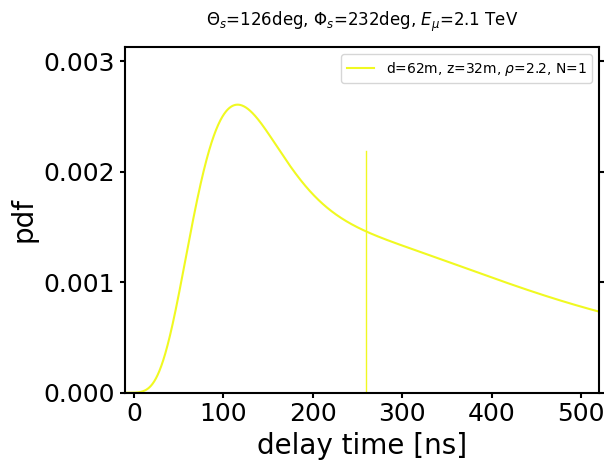

In [106]:
cmap = plt.cm.plasma
c_map = plt.cm.ScalarMappable(norm=Normalize(vmin=0, vmax=50), cmap=cmap)

dists = np.array(closest_approach_dist)
cols = [c_map.to_rgba(dist) for dist in dists]

xvals = np.linspace(-10, 3000, 30000)
xvals = xvals.reshape(30000, 1)
qtots = event_data['charge'].values

for i in range(len(dom_pos)):
    if dists[i] > 100:
        continue

    m = mix_probs[i]
    a = av[i]
    b = bv[i]
    mode = (a[1]-1)/b[1]
    yval = c_multi_gamma_prob(xvals, m, a, b, 3.0, 0.1)

    fig, ax = plt.subplots()
    plt.plot(xvals, yval, color=cols[i], label=f'd={dists[i]:.0f}m, z={float(closest_approach_z[i]):.0f}m, $\\rho$={float(closest_approach_rho[i]):.1f}, N={qtots[i]:.0f}')
    
    
    plt.axvline(x=float(delay_time[i]), ymax=0.7, linewidth=1, color=cols[i])
    
    plot_args = {'xlim':[-10, np.max([20, 5 * mode, float(delay_time[i])*1.2])],
                     'ylim':[0.0, 1.2 * np.amax(yval)],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
    zenith = np.rad2deg(meta['muon_zenith'])
    azimuth = np.rad2deg(meta['muon_azimuth'])
    adjust_plot_1d(fig, ax, plot_args=plot_args)
    plt.title(f"$\\Theta_s$={zenith:.0f}deg, $\\Phi_s$={azimuth:.0f}deg, $E_\mu$={meta['muon_energy_at_detector']/1000:.1f} TeV", pad=15)
    plt.tight_layout()
    plt.show()